In [420]:
#Librerias que estaremos utilizando
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import scipy
import scipy.stats
import random

In [421]:
#Clase auxiliar para videos

class FrameExtractor:
    
    def __init__(self,path):
        vc = cv2.VideoCapture(path)
        #Obtenemos el número de imágenes del video
        nFrames = 0
        #La frecuencia de muestreo
        fRate = vc.get(cv2.CAP_PROP_FPS)
        self.fRate = fRate
        #Leempos la captura de video
        ret,f = vc.read()
        n = f.shape[0]
        m = f.shape[1]
        #Creamos el stack de imágenes
        self.frameStack = []
        self.n = n
        self.m = m
        i = 0
        #Vamos a extraer todos los frames y se almacenaran en una pila de imagenes 
        #frame stack
        while(True):
            ret,f = vc.read()
            if(ret):
                self.frameStack.append(cv2.cvtColor(f, cv2.COLOR_BGR2GRAY))
                nFrames += 1
            else:
                break
        self.nFrames = nFrames
        vc.release()
        
    #Obtiene el frame especificado en index
    def getImg(self,index):
        if(index > self.nFrames-1):
            print("Index is out of bounds")
        else:
            return self.frameStack[index]
        
    #Obtiene el stack de imágenes
    def getImgStack(self):
        return self.frameStack
    
    #Getters para las dimensiones de la imagen
    def getHeight(self):
        return self.n
    
    def getWidth(self):
        return self.m
    
    def getFrameRate(self):
        return self.fRate
    
    def getNumberOfFrames(self):
        return self.nFrames
    
    def getDeltaT(self):
        return 1/self.fRate
    
    def getTArray(self,initialFrame):
        duration = (self.getNumberOfFrames()-initialFrame-1)*self.getDeltaT()
        return np.arange(0,duration,self.getDeltaT())

## Flujo Óptico

In [422]:
class OpticalFlowTracker:
    
    def __init__(self,frameExtractor):
        self.frameExtractor = frameExtractor
        #Algunos parámetros del Tracker que usaremos por default
        
        #Te dice que tanto se van a estar escalando las imagenes al hacer la pirámide, en este caso haremos que
        #se vaya disminuyendo a la mitad el tamaño. 
        self.pyramidScaling = 0.5
        
        #Número de niveles que tendrá la piramide:
        self.pyramidSize = 3
        
        #Tamaño de la ventana dentro de la cual detectaremos al pixel de una imágen de un frame al siguiente
        #(en el ejemplo que vimos en clase esta ventana era de tamaño 3)
        self.windowSize = 15
        
        #Iteraciones que se hacen a cada nivel de la pirámide
        self.iterations = 3
        
        #El método de Farneback usa una aproximación polinomial para encontrar los pixeles en una vecindad, debemos especificar
        #a la función el orden del polinomio 
        self.polyOrder  = 5
        self.polySigma = 1.2
        self.flags = 0
    
    def computeOpticalFlow(self):
        index = 0
        prevFrame = self.frameExtractor.getImg(index)
        gradMagnitude = np.zeros((self.frameExtractor.getHeight(),self.frameExtractor.getWidth(),self.frameExtractor.getNumberOfFrames()-1)).astype('uint8')
        gradDirection = np.zeros((self.frameExtractor.getHeight(),self.frameExtractor.getWidth(),self.frameExtractor.getNumberOfFrames()-1)).astype('uint8')
        gradientColorMap = np.zeros((self.frameExtractor.getHeight(), self.frameExtractor.getWidth(), 3, self.frameExtractor.getNumberOfFrames()-1)).astype('uint8')
        gradientColorMap[:,:,1,:] = 255
        while(index < self.frameExtractor.getNumberOfFrames()-1):
            index = index + 1
            nextFrame = self.frameExtractor.getImg(index)
            #El resultado de esto son un montón de flechitas, queremos de aquí a su magnitud y angulo (representación en polares)
            flow = cv2.calcOpticalFlowFarneback(prevFrame,nextFrame, None, self.pyramidScaling, self.pyramidSize, self.windowSize, self.iterations, self.polyOrder, self.polySigma, self.flags)
            mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])
            
            #Guardamos la magnitud y angulo
            gradMagnitude[:,:,index-1] = mag
            gradDirection[:,:,index-1] = ang
            #Para propósitos de visualización vamos a almacenar la dirección y magnitud en un mapa hsv, (basicamente este es un sistema)
            #que mide colores en coordenadas polares asi que es ideal para nosotros
            gradientColorMap[:,:,0,index-1] = ang * 180 / np.pi / 2
            gradientColorMap[:,:,2,index-1] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            #print(np.max(gradientColorMap[:,:,0,index-1]))
            bgr = cv2.cvtColor(gradientColorMap[:,:,:,index-1],cv2.COLOR_HSV2BGR)
            #rgb = bgr[...,::-1].copy()
            gradientColorMap[:,:,:,index-1] = bgr
            #print(np.max(gradientColorMap[:,:,0,index-1]))
            prevFrame = nextFrame
        
        self.gradientColorMap = gradientColorMap
        self.gradMagnitude  = gradMagnitude
        self.gradDirection = gradDirection
    
    
    def plotTrack(self,i):
        #Borramos el frame anterior
        self.ax.clear()
        self.ax.set_title(self.title)
        self.ax.imshow(self.gradientColorMap[:,:,:,i])
    
    
    def animateCloudTrack(self, title):
        self.fig, self.ax = plt.subplots()
        self.title = title
        deltaT = self.frameExtractor.getDeltaT()*(10 **3)
        anim = FuncAnimation(self.fig, self.plotTrack, frames = range(0,self.frameExtractor.getNumberOfFrames()-1), interval = deltaT, blit = False)
        return HTML(anim.to_html5_video())
    
    
    def animateArrowTrack(self,title):
        return -1
        
    #Setters y getters 
    def setPyramidScaling(scaling):
        self.pyramidScaling = scaling
    
    def setWindowSize(size):
        self.windowSize = size
    
    def setpyramidSize(pyrSize):
        self.pyramidSize = pyrSize
        
        


In [423]:
#Abrimos nuestra imagen del robot con el extractor de Frames
frames = FrameExtractor('robot.gif')
#Pasamos los frames al tracker
tracker = OpticalFlowTracker(frames)
#Vamos a probar hacer un gráfico de un frame a ver si está funcionando
tracker.computeOpticalFlow()



Text(0.5, 1.0, 'Color Map')

<Figure size 432x288 with 0 Axes>

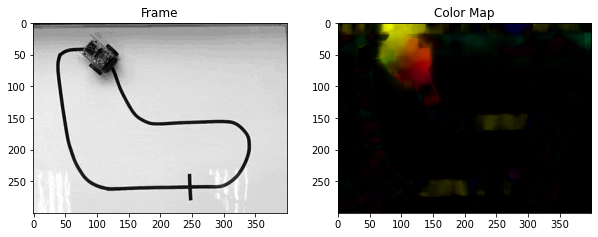

In [424]:
ind = 90
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10, 3.5))
ax[0].imshow(frames.getImg(ind),cmap = 'gray')
ax[0].set_title('Frame')
ax[1].imshow(tracker.gradientColorMap[:,:,:,ind])
ax[1].set_title('Color Map')

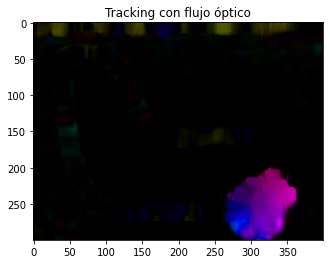

In [425]:
tracker.animateCloudTrack("Tracking con flujo óptico")

## Tracking con filtro Kalman

Para esta parte me basé en esta página https://machinelearningspace.com/2d-object-tracking-using-kalman-filter/

In [426]:

#Implementación del filtro kalman para corregir posiciones de partícula
#en 2D
class KalmanFilter:
    def __init__(self, deltaT, accX, accY, stdAcc, xStdMeas, yStdMeas):
        #Tiempo de muestreo
        self.deltaT = deltaT
        #Definimos las variables de control (aceleración)
        self.a = np.matrix([[accX],[accY]])
        #Estado inicial (el estado viene dado por [x,y,vx,vy])
        self.x = np.matrix([[0], [0], [0], [0]])
        #Matriz de transición de estados A
        self.A = np.matrix([[1, 0, self.deltaT, 0],[0, 1, 0, self.deltaT],[0, 0, 1, 0],[0, 0, 0, 1]])
        #Matriz B de control
        self.B = np.matrix([[(self.deltaT**2)/2, 0],[0, (self.deltaT**2)/2],[self.deltaT,0],[0,self.deltaT]])
        #Matriz H indicando que las variables a medir son las de posición x y
        self.H = np.matrix([[1,0,0,0],[0,1,0,0]])
        #Covarianza inicial del ruido del proceso
        self.Q = np.matrix([[(self.deltaT**4)/4, 0, (self.deltaT**3)/2, 0],[0, (self.deltaT**4)/4, 0, (self.deltaT**3)/2],[(self.deltaT**3)/2, 0, self.deltaT**2, 0],[0, (self.deltaT**3)/2, 0, self.deltaT**2]]) * stdAcc**2
        #Covarianza inicial del ruido de medición 
        self.R = np.matrix([[xStdMeas**2,0],[0, yStdMeas**2]])
        #Matriz inicial de covarianza
        self.P = np.eye(self.A.shape[1])

    #Hace las predicciones tanto de el estimado del estado xk del sistema como de 
    #la covarianza del error Pk
    def predict(self):
        #Actualizamos el estado
        #xk = Ax_k-1 + Ba__k-1
        self.x = np.dot(self.A,self.x) + np.dot(self.B,self.a)
        #Actualizamos la covarianza de error
        #P = APA' + Q 
        self.P = np.dot(np.dot(self.A,self.P),self.A.T) + self.Q
        return self.x[0:2]
    
    #Aquí usamos mediciones para refinar nuestro modelo estadístico de los errores. 
    def update(self,z):
        #S = H*P´*H' + R
        S = np.dot(self.H,np.dot(self.P,self.H.T)) + self.R
        #Ganancia de Kalman
        #K = P * H' * inv(H*P*H' + R)
        K = np.dot(np.dot(self.P,self.H.T),np.linalg.inv(S))
        
        #Actualizamos nuestro estado usamos esta ganancia de kalman
        self.x = np.round(self.x + np.dot(K,(z-np.dot(self.H,self.x))))
        
        I = np.eye(self.H.shape[1])
        
        #Actualizamos la matriz de covarianza del error
        self.P = (I-(K*self.H))*self.P
        #Regresamos la posición 
        return self.x[0:2]

class Detector:
    
    def __init__(self, frameExtractor):
        self.frameExtractor = frameExtractor
    
    
    def detectCenters(self,index):
        #Obtenemos el cuadro en el que encontraremos el centro de los objetos
        frame = self.frameExtractor.getImg(index)
        n = self.frameExtractor.getHeight()
        m = self.frameExtractor.getWidth()
        #obtenemos los bordes usando un filtro canny 
        imgEdges = cv2.Canny(frame,50,190,3)
        imgEdges = imgEdges[10:n-2,2:m-2]
        #Convertimos a imagen binaria 
        ret,imgThresh = cv2.threshold(imgEdges,254,255,cv2.THRESH_BINARY)
        #Cerramos las regiones con la operación morfológica de cierre
        se = np.ones((10,10), dtype='uint8')
        imageClose = cv2.morphologyEx(imgThresh, cv2.MORPH_CLOSE, se)
        kernel = np.ones((8,8),np.uint8)
        erosion = cv2.erode(imageClose,kernel)
        #Contornos
        contours,_ = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        #Radios minimos y máximos de los objetos detectados
        minRadiusThresh = 3
        maxRadiusThresh = 500
        centers = []
        radii = []
        for contour in contours:
            (x,y), radius = cv2.minEnclosingCircle(contour)
            radius = int(radius)
            if(radius > minRadiusThresh and radius < maxRadiusThresh):
                centers.append(np.array([[x],[y]]))
                radii.append(radius)
        
        return centers,radii
    
    
    def drawCenters(self, i):
        centers,radii = self.detectCenters(i)
        theta = np.linspace(0, 2*np.pi, 100)
        plt.figure()
        plt.title("Objetos detectados en el cuadro")
        plt.imshow(self.frameExtractor.getImg(i),cmap = "gray")
        for j in range(0,len(radii)):
            center = centers[j]
            radius = radii[j]
            centerX = center[0]
            centerY = center[1]
            x = centerX + radius*np.sin(theta)
            y = centerY + radius*np.cos(theta)
            plt.plot(x,y,color = 'b')
    
    def getBiggerObjectPosition(self,i):
        centers,radii = self.detectCenters(i)
        if(len(radii) >= 1):
            maxIndex = 0
            for i in range(1,len(radii)):
                if(radii[i] > radii[maxIndex]):
                    maxIndex = i
            return centers[maxIndex]
        else:
            return None

#Finalmente la clase para hacer tracking con Kalman
class KalmanTracker:
    
    def __init__(self,frameExtractor):
        self.frameExtractor = frameExtractor
        deltaT = frameExtractor.getDeltaT()
        self.kalmanFilter = KalmanFilter(deltaT,1,1,1,0.1,0.1)
        self.centerDetector = Detector(frameExtractor)
        
        
    def trackBiggestObject(self,squareSize,pointSize):
        trackedFrames = []
        halfSize = int(squareSize/2)
        for i in range(0,self.frameExtractor.getNumberOfFrames()):
            #Obtenemos el cuadro
            frame = self.frameExtractor.getImg(i)
            labeledFrame = frame.copy()
            #Obtenemos el centro del objeto con nuestro detector
            center = self.centerDetector.getBiggerObjectPosition(i)
            labeledFrame = cv2.cvtColor(labeledFrame,cv2.COLOR_GRAY2RGB)
            if(center.all() != None):
                x = center[0]
                y = center[1]
                #Dibujamos el centro
                cv2.circle(labeledFrame,(x,y),pointSize,(0, 191, 255),2)
                #Predecimos
                predictedPos = self.kalmanFilter.predict()
                xPred = predictedPos[0]
                yPred = predictedPos[1]
                #Dibujamos el bounding box alrededor del punto que predecimos con el filtro
                cv2.rectangle(labeledFrame,(xPred-halfSize, yPred - halfSize),(xPred + halfSize, yPred + halfSize),(0,0,255),2)
                #Actualizamos 
                updatedPos = self.kalmanFilter.update(center)
                xUpdated = updatedPos[0]
                yUpdated = updatedPos[1]
                cv2.rectangle(labeledFrame,(xUpdated-halfSize,yUpdated -halfSize),(xUpdated + halfSize, yUpdated + halfSize),(255,0,0),2)
                
                #Adornamos con un pocoi de texto
                cv2.putText(labeledFrame,"Posicion estimada",(xUpdated + halfSize ,yUpdated +halfSize),0,0.5,(255,0,0),2)
                cv2.putText(labeledFrame,"Posicion predicha",(xPred + halfSize ,yPred+halfSize),0,0.5,(0,0,255),2)
                cv2.putText(labeledFrame,"Posicion medida",(x,y-pointSize),0,0.5,(0,191,255),2)
            
            trackedFrames.append(labeledFrame)
        
        self.trackedFrames = trackedFrames
            

    def animateTrackFrames(self,title):
        self.fig, self.ax = plt.subplots()
        self.title = title
        deltaT = self.frameExtractor.getDeltaT()*(10 **3)
        anim = FuncAnimation(self.fig, self.plotTrack, frames = range(0,self.frameExtractor.getNumberOfFrames()-1), interval = deltaT, blit = False)
        return HTML(anim.to_html5_video())    
    def plotTrack(self,i):
        self.ax.clear()
        self.ax.set_title(self.title)
        self.ax.imshow(self.trackedFrames[i])
        
        
        
        
        
    
    

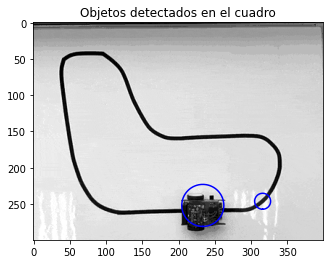

In [427]:
kalmanTracker  = KalmanTracker(frames)
kalmanTracker.centerDetector.drawCenters(0)

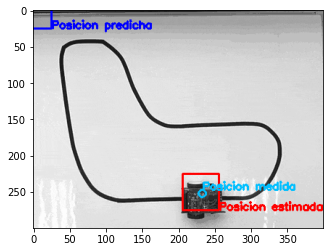

In [428]:
kalmanTracker.trackBiggestObject(50,5)
plt.figure()
plt.imshow(kalmanTracker.trackedFrames[0])

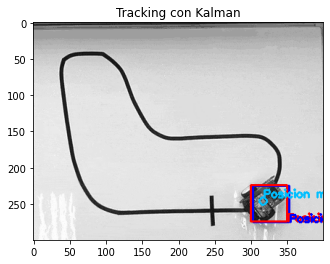

In [429]:
kalmanTracker.animateTrackFrames("Tracking con Kalman")

## Filtro de partícula

In [517]:
class ParticleFilter:
    
    def __init__(self,frameExtractor, boxSize,stdError):
        self.frameExtractor = frameExtractor
        self.numberOfParticles = 100
        self.boxSize = boxSize
        #Inicializamos los pesos de forma uniforme
        self.weights = np.zeros(self.numberOfParticles)
        self.initializeWeights()
        self.particles = np.zeros((self.numberOfParticles,3))
        self.stdError = stdError
        self.deltaT = frameExtractor.getDeltaT()
        self.centerDetector = Detector(frameExtractor)
        
    
    
    def initializeWeights(self):
        for i in range(0,len(self.weights)):
            self.weights[i] = 1
        
    def initializeParticles(self):
        self.particles[:, 0] = np.random.uniform(0, self.frameExtractor.getWidth(), size=self.numberOfParticles)
        self.particles[:, 1] = np.random.uniform(0, self.frameExtractor.getHeight(), size=self.numberOfParticles)
        self.particles[:, 2] = np.random.uniform(0, 2*np.pi, size=self.numberOfParticles)
    
    
    def predict(self, vel, std, deltaT):
        #Dirección aleatoria
        self.particles[:,2] += vel[0] + np.random.randn(self.numberOfParticles)*std[0]
        self.particles[:, 2] %= 2 * np.pi
        #Magnitud aleatoria en la dirección escogida anteriormente
        d = vel[1]*deltaT + np.random.randn(self.numberOfParticles) * std[1]
        self.particles[:, 0] += np.cos(self.particles[:, 2]) * d
        self.particles[:, 1] += np.sin(self.particles[:, 2]) * d
    
    def update(self, z):
        nm = np.linalg.norm(self.particles[:, 0:2]-z,axis = 1)
        dist = np.linalg.norm(self.particles[:, 0:2],axis = 1)
        self.weights *= scipy.stats.norm(0, self.stdError).pdf(nm)
        self.weights /= sum(self.weights) # normalize
        
    
    def resample(self):
        cumulativeSum = np.cumsum(self.weights)
        cumulativeSum[-1] = 1. # avoid round-off error
        indexes = np.searchsorted(cumulativeSum, np.random.random(self.numberOfParticles))
    
        # resample according to indexes
        self.particles = self.particles[indexes]
        self.weights = self.weights[indexes]
        self.weights /= np.sum(self.weights) # normalize
       # print(np.max(self.weights))
    
        
    def trackObject(self):
        trackImages = []
        #Comenzamos inicializando los pesos y las particulas en posiciones aleatorias
        self.initializeWeights()
        self.initializeParticles()
        index = 0
        numFrames = self.frameExtractor.getNumberOfFrames()
        #El cuadro inicial
        halfSize = int(self.boxSize/2)
        
        
        
        for i in range(0, numFrames):
            self.predict((5, 5), (4, 4), 1)
            center = self.centerDetector.getBiggerObjectPosition(i)
            self.update(center.T)
            self.resample()
            labeledFrame = self.frameExtractor.getImg(i).copy()
            labeledFrame = cv2.cvtColor(labeledFrame,cv2.COLOR_GRAY2RGB)
            for i in range(0,self.numberOfParticles):
                particle = self.particles[i,:]
                x = int(particle[0])
                y = int(particle[1])
                cv2.rectangle(labeledFrame,(x-halfSize, y - halfSize),(x + halfSize, y + halfSize),(0,0,255),2)
            trackImages.append(labeledFrame)

        self.trackImages = trackImages
    
    def animateTrackFrames(self,title):
        self.fig, self.ax = plt.subplots()
        self.title = title
        deltaT = self.frameExtractor.getDeltaT()*(10 **3)
        anim = FuncAnimation(self.fig, self.plotTrack, frames = range(0,self.frameExtractor.getNumberOfFrames()-1), interval = deltaT, blit = False)
        return HTML(anim.to_html5_video())    
    
    def plotTrack(self,i):
        self.ax.clear()
        self.ax.set_title(self.title)
        self.ax.imshow(self.trackImages[i])

                        
    
    

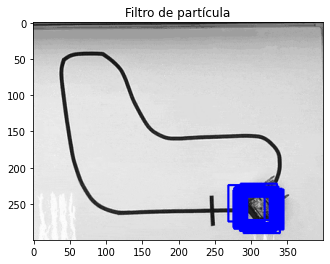

In [518]:
pFilter = ParticleFilter(frames,50,10)
pFilter.trackObject()
pFilter.animateTrackFrames("Filtro de partícula")

In [450]:
scipy.stats

<module 'scipy.stats' from 'C:\\Users\\walup\\anaconda3\\lib\\site-packages\\scipy\\stats\\__init__.py'>

In [462]:
np.linalg.norm([[1,2],[2,3]],axis = 1)

array([2.23606798, 3.60555128])

In [465]:
np.linalg.norm([1,2])

2.23606797749979